# Part II: Building a dataset and data exploration

Date: 25/08/2022

Authors: Jordi Bolibar & Facundo Sapienza

Once we have successfully retrieved the training dataset using OGGM, we can start exploring and understanding the dataset. The goal of this notebook will be to perform some basic data analysis techniques on the data, and to understand the physical reasons behind the selected features for the model. 

> **_NOTE_** Before running this notebook, make sure your Jupyter kernel (top left corner of the notebook) has been configured to work with the *Finse_MB* conda environment. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2.1 Data Preparation

The MB remote sensing from Hugonnet et al. (2021) covers periods of 10 years (2000-2010 and 2010-2020). We will process the feature matrix to match these 10 year intervals. First of all, we will assign to each hydrological year in every period 2000-2010 and 2010-2020 the same part of mass balance that results from grabing the total mass balance from the period and divide it by 10. 

In [7]:
#df_target = pd.read_csv('Data/mb_df.csv')
df_target = pd.read_csv('/home/jovyan/shared/glacier-ml-2022/Mass_Balance_ML_Modelling/Data/mb_df.csv')

# Restrict to the two target peroids we have for training
df_target = df_target.replace({'2000-01-01_2010-01-01': '2000-2010',
                               '2010-01-01_2020-01-01': '2010-2020'})
df_target = df_target[df_target.period.isin(['2000-2010', '2010-2020'])]
# We add an unique id to each row to recognized repeited measurements 
df_target['target_id'] = np.arange(0, df_target.shape[0])

# Add hydro year of the target 
dfs = []
for i in range(10):
    df_ = df_target.copy()
    df_['hydro_year'] = np.select([(df_.period=='2000-2010'),
                                         (df_.period=='2010-2020')], 
                                         [2000+i, 2010+i])
    dfs.append(df_)

df_target = pd.concat(dfs, axis=0)
df_target = df_target.set_index(['rgi_id', 'hydro_year'])
df_target = df_target.sort_values(['rgi_id', 'hydro_year'])
df_target = df_target[['dmdtda', 'err_dmdtda', 'period','target_id']]
df_target

dmdtda  err_dmdtda     period  target_id
rgi_id         hydro_year                                            
RGI60-08.00001 2000       -0.458772     0.44912  2000-2010          0
               2001       -0.458772     0.44912  2000-2010          0
               2002       -0.458772     0.44912  2000-2010          0
               2003       -0.458772     0.44912  2000-2010          0
               2004       -0.458772     0.44912  2000-2010          0
...                             ...         ...        ...        ...
RGI60-08.03417 2015        0.389200     0.49660  2010-2020       6833
               2016        0.389200     0.49660  2010-2020       6833
               2017        0.389200     0.49660  2010-2020       6833
               2018        0.389200     0.49660  2010-2020       6833
               2019        0.389200     0.49660  2010-2020       6833

[68340 rows x 4 columns]

We now read the feature matrix and merge it with the target response (the MB data from Hugonnet et al.(2021)).

In [8]:
#df_features = pd.read_csv('Data/training_df.csv', index_col=['rgi_id', 'hydro_year'])
df_features = pd.read_csv('/home/jovyan/shared/glacier-ml-2022/Mass_Balance_ML_Modelling/Data/training_df.csv', index_col=['rgi_id', 'hydro_year'])
df_features

PDD  area  icecap     lat     lon  \
rgi_id         hydro_year                                            
RGI60-08.00001 2000        40.322890  0.03       0  67.930  33.830   
               2001        42.489556  0.03       0  67.930  33.830   
               2002        38.044445  0.03       0  67.930  33.830   
               2003        39.844445  0.03       0  67.930  33.830   
               2004        40.577779  0.03       0  67.930  33.830   
...                              ...   ...     ...     ...     ...   
RGI60-08.03417 2015        51.437776  0.15       0  65.923  14.221   
               2016        55.643333  0.15       0  65.923  14.221   
               2017        50.003331  0.15       0  65.923  14.221   
               2018        57.004444  0.15       0  65.923  14.221   
               2019        54.643332  0.15       0  65.923  14.221   

                              prcp_01     prcp_02     prcp_03     prcp_04  \
rgi_id         hydro_year                                                   
RGI60-08.00001 2000         89.949440   39.799580   51.759113   50.980053   
               2001         50.515020   43.414460   49.670944   27.386324   
               2002         59.345170   29.263450   24.280972   44.494130   
               2003         48.070133   34.243984   27.780344   46.093716   
               2004         78.174040   31.993261   62.266920   28.106590   
...                               ...         ...         ...         ...   
RGI60-08.03417 2015        104.149030  111.409660  266.413970  155.734220   
               2016        217.098800  211.801880  242.586320  101.253310   
               2017         89.045910  149.197240  371.887760  299.347630   
               2018        176.113360  158.276730  192.674560   64.232956   
               2019        217.587550  137.044170  171.008670  167.764050   

                              prcp_05  ...    temp_06   temp_07   temp_08  \
rgi_id         hydro_year              ...                                  
RGI60-08.00001 2000         29.002270  ...  -7.277111 -2.398222  2.567333   
               2001         35.375156  ... -12.677110 -2.531555  0.867333   
               2002         44.540123  ...  -8.710444 -1.564889  2.667333   
               2003         26.073019  ...  -6.277111 -3.898222  3.467333   
               2004         40.665600  ...  -7.777110 -2.964889  2.367333   
...                               ...  ...        ...       ...       ...   
RGI60-08.03417 2015        189.870130  ...  -0.210000  1.001111  4.812222   
               2016        108.876656  ...  -1.309999  1.034444  6.578889   
               2017        121.731080  ...  -2.710000 -0.498889  3.845556   
               2018         24.806946  ...  -6.509999  1.001111  8.078889   
               2019        227.375120  ...  -3.910000  2.701111  4.512222   

                             temp_09    temp_10    temp_11   temp_12    zmax  \
rgi_id         hydro_year                                                      
RGI60-08.00001 2000         8.536221  12.828446   9.784000  5.261779   250.0   
               2001         9.336221  12.928445   9.650667  6.961779   250.0   
               2002         8.536221  13.128446   9.650667  4.061778   250.0   
               2003         5.469554  14.428445  10.650667  5.828445   250.0   
               2004         7.436221  14.061779  10.550666  6.161778   250.0   
...                              ...        ...        ...       ...     ...   
RGI60-08.03417 2015         7.797778  10.972221  13.489999  9.380000  1318.0   
               2016         9.397778  12.872221  11.089999  9.780001  1318.0   
               2017         9.997778  11.972221  11.289999  9.380000  1318.0   
               2018         8.497778  15.072221  11.890000  8.480001  1318.0   
               2019        10.164444  12.672220  12.489999  7.480001  1318.0   

                             zmed    zmin  
rgi_id         hydro_year        

We aggregate the periods 2000-2010 and 2010-2020 into one single datapoint for training by setting `aggregation=True`. This makes sense if we are interested in learning just the mass balance in these 10 years periods. However, if we want to have a better resolution and learn the variation of mass balance every one year we may decide to go for the other. This will be harder to train and also more difficult to test without the use of an external dataset. 

At this point, going for an annual resolution instead of the 10-year resolution of the target dataset doesn't make much sense. The spatiotemporal resolution limits model capabilities (see  explanations below in section "**Choosing the right data and understanding the implications in model design**").

In [10]:
aggregation = True

df_all = df_features.merge(df_target, 
                           left_on=['rgi_id','hydro_year'], 
                           right_on=['rgi_id','hydro_year'])#.drop(['RGI_ID'], axis=1)

if aggregation:
    df_all = df_all.groupby(['rgi_id', 'period']).mean()
df_all

PDD    area  icecap     lat     lon  \
rgi_id         period                                                 
RGI60-08.00001 2000-2010  39.787001   0.030     0.0  67.930  33.830   
               2010-2020  41.833601   0.030     0.0  67.930  33.830   
RGI60-08.00002 2000-2010  44.907200   0.030     0.0  67.870  33.500   
               2010-2020  46.980223   0.030     0.0  67.870  33.500   
RGI60-08.00003 2000-2010  35.337201   0.020     0.0  67.820  33.750   
...                             ...     ...     ...     ...     ...   
RGI60-08.03415 2010-2020  34.757735   0.056     0.0  66.729  15.203   
RGI60-08.03416 2000-2010  66.325377  14.152     0.0  66.006  14.296   
               2010-2020  66.505066  14.152     0.0  66.006  14.296   
RGI60-08.03417 2000-2010  53.358777   0.150     0.0  65.923  14.221   
               2010-2020  53.116888   0.150     0.0  65.923  14.221   

                             prcp_01     prcp_02     prcp_03     prcp_04  \
rgi_id         period                                                      
RGI60-08.00001 2000-2010   59.556398   42.393607   49.464068   40.707838   
               2010-2020   57.685775   45.119089   49.848962   37.706104   
RGI60-08.00002 2000-2010   62.082497   43.677873   49.432192   41.313322   
               2010-2020   59.345685   45.845166   49.957571   37.644466   
RGI60-08.00003 2000-2010   60.485810   45.600863   55.059464   46.842254   
...                              ...         ...         ...         ...   
RGI60-08.03415 2010-2020  131.108065  107.707591  144.610990   98.574383   
RGI60-08.03416 2000-2010  160.244277  183.438569  186.103358  190.792902   
               2010-2020  174.868147  146.277851  205.123464  136.355639   
RGI60-08.03417 2000-2010  152.880332  173.554018  177.555157  183.980329   
               2010-2020  165.529468  138.168895  196.729779  132.081722   

                             prcp_05  ...    temp_09    temp_10    temp_11  \
rgi_id         period                 ...                                    
RGI60-08.00001 2000-2010   28.460900  ...   8.099555  12.371779  10.284000   
               2010-2020   33.120270  ...   8.276221  12.368446  10.454000   
RGI60-08.00002 2000-2010   28.519503  ...   9.070814  13.313038  11.180073   
               2010-2020   32.577409  ...   9.219703  13.334149  11.296740   
RGI60-08.00003 2000-2010   33.796713  ...   7.263999  11.637335   9.550666   
...                              ...  ...        ...        ...        ...   
RGI60-08.03415 2010-2020   92.859806  ...   6.468000  10.121335   9.334667   
RGI60-08.03416 2000-2010  139.485696  ...  11.302889  14.521777  13.777333   
               2010-2020  129.459209  ...  10.972889  14.288444  13.650666   
RGI60-08.03417 2000-2010  133.112843  ...   9.767778  12.995554  12.039999   
               2010-2020  123.916238  ...   9.437778  12.778888  11.926666   

                            temp_12    zmax    zmed    zmin    dmdtda  \
rgi_id         period                                                   
RGI60-08.00001 2000-2010   5.725112   250.0   242.0   235.0 -0.458772   
               2010-2020   6.561779   250.0   242.0   235.0 -0.356250   
RGI60-08.00002 2000-2010   6.580445   246.0   239.0   228.0 -0.458772   
               2010-2020   7.428223   246.0   239.0   228.0 -0.356250   
RGI60-08.00003 2000-2010   4.904001   749.0   726.0   701.0 -0.458772   
...                             ...     ...     ...     ...       ...   
RGI60-08.03415 2010-2020   5.741333  1330.0  1314.0  1289.0  0.534500   
RGI60-08.03416 2000-2010   9.584000  1811.0  1581.0   890.0 -0.737400   
               2010-2020  10.307334  1811.0  1581.0   890.0 -0.649400   
RGI60-08.03417 2000-2010   7.853334  1318.0  1186.0  1090.0 -0.616100   
               2010-2020   8.560001  1318.0  1186.0  1090.0  0.389200   

                          err_dmdtda  target_id  
rgi_id         period                            
RGI60-08.00001 2000-2010    0.449120        0.0  
    

In [11]:
df_all.to_csv('Data/df_all.csv')

## 2.2 Preliminary statistics of the dataset

A simple look at the mass balance distribition shows that most of the mass balance rates are mostly negative. 

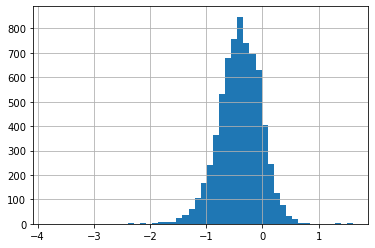

In [12]:
df_all['dmdtda'].hist(bins=50);

<AxesSubplot:>

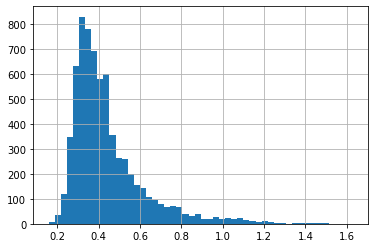

In [14]:
df_all['err_dmdtda'].hist(bins=50)

<AxesSubplot:xlabel='area', ylabel='err_dmdtda'>

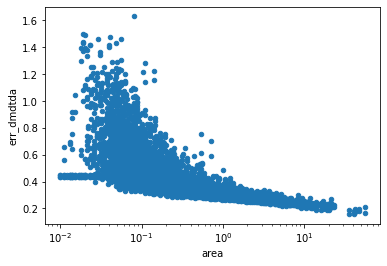

In [28]:
df_all.plot.scatter('area','err_dmdtda', logx=True)

### [ **Exercice 1** ]
<img src="Figures/eye_logo.png" width="75"/>

What other sorts of data analyses can you think of? Implement them in this section by plotting different graphs and statistics. 

## 2.3 How to build a good dataset

Now that we have the dataset ready, let's take a look at the features:

In [13]:
df_all.columns

Index(['PDD', 'area', 'icecap', 'lat', 'lon', 'prcp_01', 'prcp_02', 'prcp_03',
       'prcp_04', 'prcp_05', 'prcp_06', 'prcp_07', 'prcp_08', 'prcp_09',
       'prcp_10', 'prcp_11', 'prcp_12', 'rain', 'slope', 'snow', 'temp_01',
       'temp_02', 'temp_03', 'temp_04', 'temp_05', 'temp_06', 'temp_07',
       'temp_08', 'temp_09', 'temp_10', 'temp_11', 'temp_12', 'zmax', 'zmed',
       'zmin', 'dmdtda', 'err_dmdtda', 'target_id'],
      dtype='object')

In this dataset we have already narrowed down a selection of training features for you. Nonetheless, in a research project, this step should not be taken for granted, since it can have a great impact on model design. 

### 2.3.1 Informed feature selection

The first question we should ask ouselves is: what variables affect the physical process we are trying to model here? In this case, we are talking about **glacier-wide mass balance**. Theory tells us that the integrated mass balance over the whole surface area of a glacier is impacted by both the climate and the 
topography of a glacier. 

Unlike point mass balance, the hypsometry of a glacier has a great impact on its glacier-wide mass balance. This is mainly manifested in two ways:

- The glacier surface slope affects ice flow dynamics, particularly the creep component. Generally, steeper glaciers have higher ice velocities, which imply a faster transfer of ice from the higher altitudes in the accumulation area to the lower altitudes in the ablation area. Therefore, a steep glacier will retreat faster (i.e. smaller surface area and higher mean altitude), but it will be able to move to higher altiudes with a colder climate. This helps the glacier find new colder climates in an effort to reach equilibrium. On the other hand, flatter glaciers and ice caps will not retreate as fast, since they react mostly through thinning (see Figure 1). This means that the glacier will move to lower altitudes with a warmer climate, further enhancing melt. This has an opposite effect to the one from steep mountain glaciers. 

- Steep mountain glaciers have a larger altitudinal range, meaning that their mass balance gradient will be steeper and likely more complex. For such glaciers, both ice flow dynamics and mass balance can play an important role in glacier evolution. On the other hand, small glaciers and to some extent ice caps, behave more similar to an ice cube: the reduced role of ice dynamics and their small altitudinal range imply a smaller mass balance gradient. For such glaciers, mass balance is the main contributor to glacier evolution.

<img src="Figures/Hock_Huss_glacier_icecap.png" class="center" width="700"/>

*Figure 1. Retreat patterns for mountain glaciers and ice caps. Taken from Hock and Huss (2021)*


### 2.3.2 Choosing the right data and understanding the implications in model design

The next question when building a dataset would be: what available data at the spatial and temporal scales that we are trying to model can I access? 

Ideally, we would always want to have a dense spatiotemporal dataset covering all the possible dynamics in the physical process we want to model. However, sadly in reality this is (almost) never possible. Two main limitations are often present:

- The spatial and temporal resolution of the dataset are too low. The dataset might be rich in one of the two dimensions, e.g. a great spatial coverage, but it has a low temporal resolution (e.g. a multi-annual resolution). When using such data to train the model, we need to be mindful of the impact in model capabilities and performance. Training a model with such data will restrict its predicting capabilities to spatiotemporal resolutions similar to those it has seen during training. 

- The spatiotemporal coverage of the data. Even if the data has the right spatiotemporal resolution, it normally only covers part of the temporal and spatial domain we want to model. This is often the case for reconstruction problems, where we ask the model to "fill the gaps" in the dataset. For such cases, we need to be mindful of what type of data coverage we have, and what type of instances or data ranges we might be missing in the dataset. This will determine the capabilities of the model in terms of prediction and generalization. The more variability and dynamics are present in the dataset, the more chances we have to build a good model. For cases where important parts of the dynamics are missing, adding physical constraints (e.g. using PINNs or Universal Differential Equations) is a good way to overcome this. The physical constraints can help guide the learning, reducing the need for bigger and more complete datasets.